In [1]:
! git clone https://github.com/ekhiru/top-k-mallows

fatal : le chemin de destination 'top-k-mallows' existe déjà et n'est pas un répertoire vide.


In [2]:
from scipy.spatial.distance import pdist
import collections
import seaborn as sns
import subprocess
import numpy as np
import itertools as it
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from  imp import reload
import sys
sys.path.append('top-k-mallows/')
import mallows_kendall as mk
import permutil as pu

/tmp/ipykernel_53751/3411056220.py:10: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from  imp import reload


# Plackett-Luce PL distributions

we use a parameter `phi` to generate  PL distributions. It controls both the location (the mode) and the variance. we could give concentration measures such as expected distance form the mode

- phi = -1 -> mode in the reverse of identity permutaion (5,4,3,2,1), small variance
- phi =  -> uniform distribution over all the permus, high variance
- phi = 1 -> mode in the idemtity permutation (1, 2, 3, ..., n ) , large variance


The following is some illlustration on the different settings of phi ( on the reultsing PL distribution, you can see this as a

-1.0  , the probability of e is: 5.780111869675654e-22 , rev(e): 0.020192399479783622
-0.75  , the probability of e is: 1.1042126951732606e-17 , rev(e): 0.005017547588027264
-0.5  , the probability of e is: 1.1042957974974056e-13 , rev(e): 0.0006526964675212318
-0.25  , the probability of e is: 3.864368496619603e-10 , rev(e): 2.9709233996126372e-05
0.0  , the probability of e is: 2.755731922398589e-07 , rev(e): 2.755731922398589e-07
0.25  , the probability of e is: 2.970923399612637e-05 , rev(e): 3.864368496619605e-10
0.5  , the probability of e is: 0.0006526964675212315 , rev(e): 1.1042957974974048e-13
0.75  , the probability of e is: 0.0050175475880272664 , rev(e): 1.1042126951732606e-17
1.0  , the probability of e is: 0.020192399479783626 , rev(e): 5.780111869675648e-22


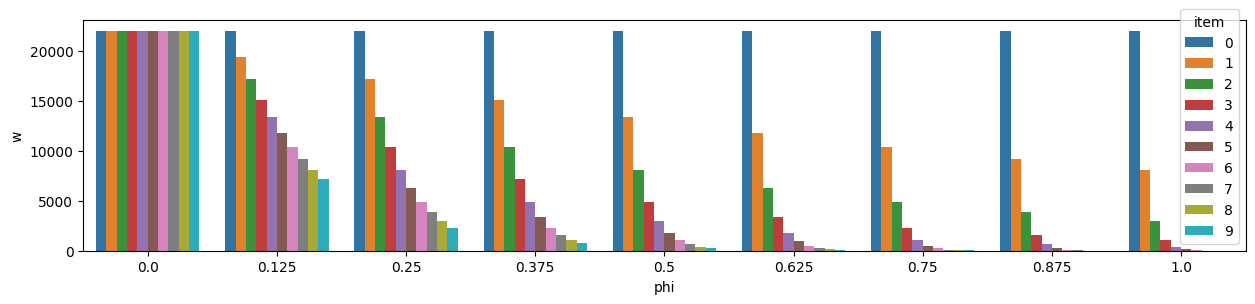

In [3]:
n = 10 # numer of systems
m = 8 # numner of metrics
p = 10# number of utterances
def phi_to_w(phi):
    return np.exp([n-phi*i for i in range(n)])

df = pd.DataFrame()
res = []
for phi in np.linspace(-1,1,9):
    w = phi_to_w(phi)
    print(phi, " , the probability of e is:",pu.pl_proba(list(range(n)), w),", rev(e):", pu.pl_proba(list(range(n))[::-1], w))
for phi in np.linspace(0,1,9):
    w = phi_to_w(phi)
    for inde,myw in enumerate(w):
        res.append([phi,inde,myw])
df = pd.DataFrame(res,columns=['phi','item','w'])
f, ax = plt.subplots(1, figsize=(15,3))
sns.barplot(hue="item", y="w", x="phi", data=df,ax=ax)
w = df[df.phi==1].w.values

In [4]:

n = 10 # numer of systems
m = 7 # numner of metrics
p = 5 # number of utterances
repes = 20


def borda(rankings):
    return np.argsort(np.argsort(rankings.sum(axis=0)))

def borda_u_m(df):
    res = []
    for i in df.Uterance.drop_duplicates().values:
        rans = df[(df.Uterance==i)].ran.values
        res.append(borda(rans))
    
    return borda(np.array(res))
  
def borda_m_u(df):
    res = []
    for i in df.Metric.drop_duplicates().values:
        rans = df[(df.Metric==i)].ran.values
        res.append(borda(rans))
    return borda(np.array(res))


def create_df_honest(m,n,p,phi):#all are sampled from the same distri
    res = []
    w = phi_to_w(phi)
    for m_i in range(m):
        ranks = pu.plackett_luce_sample(p,n,w=w)
        for inde,ran in enumerate(ranks):
            res.append([m_i,inde,ran])
            
    dfhonest = pd.DataFrame(res,columns = ['Metric', 'Uterance', 'ran'])
    return dfhonest


In [5]:
create_df_honest(3,4,5,0).head()

,Metric,Uterance,ran
0,0,0,"[3.0, 2.0, 0.0, 1.0]"
1,0,1,"[2.0, 1.0, 3.0, 0.0]"
2,0,2,"[0.0, 3.0, 1.0, 2.0]"
3,0,3,"[2.0, 1.0, 3.0, 0.0]"
4,0,4,"[3.0, 0.0, 2.0, 1.0]"


## toy synthetic example

There is a honeset sample:
    $n$ systems, $m$ metrics and $p$ uterances :  sample from a PL the rankings of the $n$ systems
    
there is a manipulator (a metric) who ranks 
phi manipu and phi honest range

(array([10.35,  9.55, 10.55]), array([7.41130893, 7.7296507 , 7.85795775]))

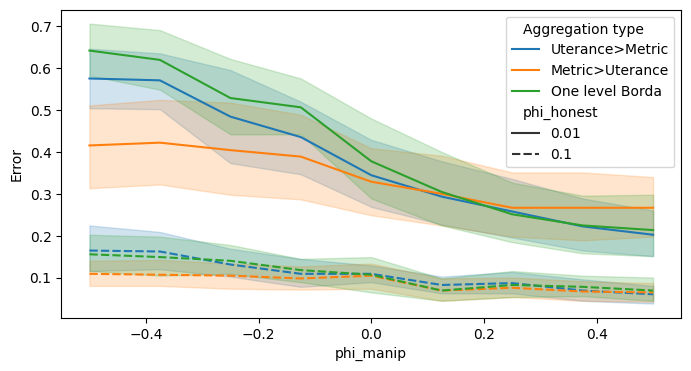

In [6]:
#   borda_u_m_true = borda_u_m(dfhonest)
#   borda_m_u_true = borda_m_u(dfhonest)
#   borda_true = borda(dfhonest.ran.values)
# the corrruption is in the metric, therefore a nmew metric , just one phi (w)


n = 10 # numer of systems
m = 10 # numner of metrics
p = 10 # number of utterances
repes = 10
N = n*(n-1)/2

reshonest, sol=[] , []
for rep in range(repes):
  for phi_honest in [.01, .1] : #np.linspace(0,.1, 2):
    dfhonest = create_df_honest(m,n,p, phi_honest)
    reshonest.append([mk.distance(borda_u_m(dfhonest)), 
                      mk.distance(borda_m_u(dfhonest)),
                      mk.distance(borda(dfhonest.ran.values))])
    for phi_manip in np.linspace(-0.5,.5,9):
      res =[]
      w = phi_to_w(phi_manip)
      ranks = pu.plackett_luce_sample(p,n,w=w)
#       print(ranks)
      for inde,ran in enumerate(ranks):
        res.append([-1,inde,ran])
      df = pd.DataFrame(res,columns = ['Metric', 'Uterance', 'ran'])
      df = pd.concat([dfhonest,df])
#       print(borda_m_u(df), borda_u_m(df), borda(df.ran.values))
      error_um = mk.distance(borda_u_m(df))/N # assuming e is the groupnd truth
      error_mu = mk.distance(borda_m_u(df))/N
      error_bo = mk.distance(borda(df.ran.values))/N
      sol.append([phi_honest,phi_manip,rep,error_um, error_mu, error_bo])
  #     print(phi_manip, error_um, error_mu, error_bo)
  
df = pd.DataFrame(sol,columns=['phi_honest','phi_manip','rep', 'error_um', 'error_mu', 'error_bo'])
df = df.melt(id_vars=['phi_honest','phi_manip'], value_vars=['error_um', 'error_mu', 'error_bo'],
             value_name='Error', var_name='Aggregation type')
df['Aggregation type'] = df['Aggregation type'].str.replace('error_um','Uterance>Metric')
df['Aggregation type'] = df['Aggregation type'].str.replace('error_mu','Metric>Uterance')
df['Aggregation type'] = df['Aggregation type'].str.replace('error_bo','One level Borda')
f, ax = plt.subplots(1, figsize=(8,4))
# ax.set_yscale('log')
sns.lineplot(data=df, style="phi_honest", x="phi_manip", hue="Aggregation type", y="Error")
np.array(reshonest).mean(axis=0),np.array(reshonest).std(axis=0)

# Scores

For the same data generation process we use scores instead of rankings: 

Instead of sampling rankings, we sample the scores form the gumbels. 
Then aggregate them (with the mean)

    - (a) only the honest samples
    - (b) both honest and manipulators
    
We give the results as the kendall correlation between (a) and (b)

We can extend to other correlation measures, and will have the same resutls

<AxesSubplot: xlabel='phi_manip', ylabel='Error'>

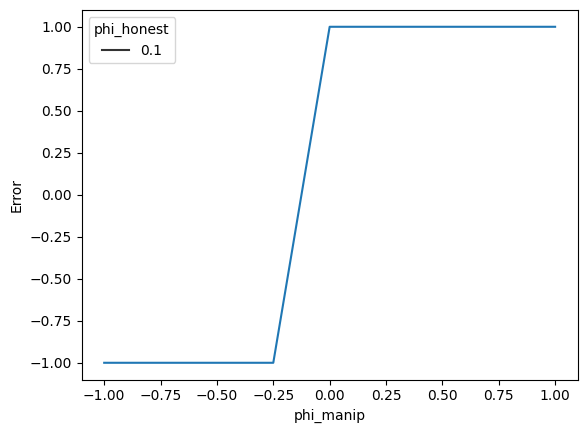

In [7]:
import scipy
repes = 4
for repe in range(repes):
    res = []
    scores_honest = np.array([np.random.gumbel(phi_to_w(phi_honest), 1) for i in range(m*p)])
    mean_honest = scores_honest.mean(axis=0)
    for phi_manip in np.linspace(-1,1,9):
        w = phi_to_w(phi_manip)
        scores_manip = np.array([np.random.gumbel(w, 1) for i in range(m*p)])
        mean_all = np.concatenate([scores_honest,scores_manip]).mean(axis=0)
        ken = scipy.stats.kendalltau(mean_all,mean_honest)[0]
        res.append([phi_honest, phi_manip, ken, repe])
df = pd.DataFrame(res,columns=['phi_honest', 'phi_manip', 'Error', 'repe'])
sns.lineplot(data=df, style="phi_honest", x="phi_manip", y="Error") # more correlations  as hue="Aggregation type"